# Modelo de segmentación de Patentes

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ja.meza@profesor.duoc.cl

**Fecha de Creación:** Septiembre de 2024  
**Versión:** 1.1 (incluye el uso de los términos 4.0)  

---

## Descripción

Este notebook realiza una segmentación de las patentes.

Para reducir la complejidad se trabaja con reducción de la dimensionalidad:

+ PCA no puede manejar matrices dispersas, pero TruncatedSVD está diseñado específicamente para trabajar con ellas.

+ TruncatedSVD se aplica directamente a la salida dispersa del TfidfVectorizer, mientras que PCA necesita matrices densas, lo que sería ineficiente en términos de memoria y tiempo computacional con documentos de gran tamaño.

Para evaluar el modelo de segmentación se usan 3 índices:

+ Silhouette. Mide qué tan cerca están los puntos dentro de un clúster entre sí, en comparación con los puntos de otros clústeres. Su valor varía entre -1 y 1. Un valor cercano a 1 indica que los documentos están bien agrupados.
+ Davies-Bouldin. Mide la relación entre la distancia entre los clústeres y la dispersión dentro de los clústeres. Un valor más bajo indica una mejor segmentación.
+ Calinski-Harabasz. Mide la dispersión dentro de los clústeres y la separación entre ellos. A mayor valor, mejor es el agrupamiento.


---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.8. A continuación se listan las bibliotecas necesarias:

- pandas (>=1.1.0)
- scikit-learn (>=0.24.0)
- openpyxl (>=3.0.0) para la exportación a Excel

Para verificar si está instalado openpyxl ejecutar:

```bash
pip show openpyxl
```
En caso de que no esté instalado se puede instalar las bibliotecas ejecutando:

```bash
pip install nltk scikit-learn openpyxl
```
En caso de que openpyxl esté instalado entonces sólo nltk y scikit-learn ejecutando:

```bash
pip install nltk scikit-learn
```

In [1]:
!mkdir -p /config
# Descargar el archivo a la carpeta config
!wget -P config https://raw.githubusercontent.com/jamezahidalgo/analisis_patentes/master/config/config.json


--2024-10-21 23:58:02--  https://raw.githubusercontent.com/jamezahidalgo/analisis_patentes/master/config/config.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1858 (1.8K) [text/plain]
Saving to: ‘config/config.json’

config.json         100%[===================>]   1.81K  --.-KB/s    in 0s      

2024-10-21 23:58:02 (18.7 MB/s) - ‘config/config.json’ saved [1858/1858]



In [2]:
!mkdir -p /data

# Descargar el archivo a la carpeta data
!wget -P data https://raw.githubusercontent.com/jamezahidalgo/analisis_patentes/master/data/data_patentes_segmentacion.zip

# Descomprimir el archivo directamente dentro de la carpeta data
!unzip -q data/data_patentes_segmentacion.zip -d data

# Eliminar el archivo zip
!rm data/data_patentes_segmentacion.zip

# Eliminar la carpeta __MACOSX si se creó
!rm -rf data/__MACOSX

!rm -rf __MACOSX


--2024-10-21 23:58:07--  https://raw.githubusercontent.com/jamezahidalgo/analisis_patentes/master/data/data_patentes_segmentacion.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4403564 (4.2M) [application/zip]
Saving to: ‘data/data_patentes_segmentacion.zip’

data_patentes_segme 100%[===================>]   4.20M  --.-KB/s    in 0.1s    

2024-10-21 23:58:08 (42.5 MB/s) - ‘data/data_patentes_segmentacion.zip’ saved [4403564/4403564]



In [4]:
!pip install nltk scikit-learn

In [5]:
!pip install kneed

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import json
import re
import pickle

import os

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE

from kneed import KneeLocator
from wordcloud import WordCloud

In [7]:
# Cargar el conjunto de datos
data = pd.read_csv('data/data_patentes_segmentacion.csv', sep="\t")

In [8]:
# Abrir y leer el archivo JSON
ruta_archivo = "config/config.json"
with open(ruta_archivo, 'r') as file:
  datos = json.load(file)
  areas = [item['nombre'] for item in datos['areas']]
  terminos = [item for item in datos['tecnologias']]

# Lista de áreas de conocimiento de las patentes
print(areas)
# Lista de términos relacionados con tecnologías 4.0
print(terminos)

['Concentración minerales', 'Pirometalurgia', 'Hidrometalurgia', 'Extracción de minerales']
['sensor', 'machine learning', 'iot', 'internet of things', 'ai', 'artificial intelligence', 'simulation', 'simulator', 'digital twin', 'digital twins', 'virtual reality', 'vr', 'augmented reality', 'ar', 'robot', 'robotic', 'robotics', '3d', 'smart', 'data', 'big data', 'automation', 'deep learning', 'predictive', 'system integration', 'cloud', 'blockchain']


In [10]:
# Cantidad de términos disponibles
len(terminos)

27

# Preprocesamiento de los datos

In [9]:
# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar caracteres especiales
    text = re.sub(r'\W+', ' ', text)
    # Tokenizar
    tokens = word_tokenize(text)
    # Eliminar stopwords y aplicar lematización
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

# Aplicar la función a las columnas de título y abstract
data['clean_title'] = data['title'].apply(preprocess_text)
data['clean_abstract'] = data['abstract'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [11]:
# Vectorizar los términos tecnológicos
tech_vectorizer = TfidfVectorizer(stop_words='english')
X_tech_terms = tech_vectorizer.fit_transform(terminos)

# Iterar por cada área

En esta sección se generan los modelos de segmentación para cada área. Esto permite poder usarlo con otras patentes (de la misma área) y de esa forma dirá a qué grupo del área pertenece esa nueva patente.

Se genera un modelo por cada área considerando el formato:

modelo_segmentación_*nombre_area*

In [12]:
def similitud_en_cluster(clusters : np.array, X):
    # Calcular la similitud de coseno entre todos los documentos
    similitudes_coseno = cosine_similarity(X)

    # Crear un diccionario para almacenar las similitudes promedio de cada clúster
    similitud_promedio_clusters = {}

    # Iterar sobre cada clúster
    for cluster in np.unique(clusters):
      # Obtener los índices de los documentos que pertenecen a este clúster
      indices_cluster = np.where(clusters == cluster)[0]

      # Extraer la submatriz de similitudes para los documentos de este clúster
      submatriz_similitudes = similitudes_coseno[indices_cluster][:, indices_cluster]

      # Calcular la similitud promedio dentro del clúster (evitando la diagonal)
      similitud_promedio = np.mean(submatriz_similitudes[np.triu_indices_from(submatriz_similitudes, k=1)])

      # Almacenar la similitud promedio del clúster
      similitud_promedio_clusters[cluster] = similitud_promedio

    return similitud_promedio_clusters

In [16]:
def save_model(model, filename = "segmentation_model"):
  """ Guarda el modelo en un archivo para su posterior uso """
  file_model = open(filename, 'wb')
  # Guarda en el archivo el mejor modelo
  pickle.dump(model, file_model)
  # Cerrar el archivo
  file_model.close()

In [17]:
def proceso_area(data : pd.DataFrame, target_area : str,
                 target_componentes = 2,
                 max_clusters = 20, target_curve = "convex"):
    # Filtrar las patentes de la misma área
    data_area = data[data['area'] == target_area].copy()

    # Preprocesar los textos
    data_area['clean_combined_text'] = data_area['title'].apply(preprocess_text) + ' ' + data_area['abstract'].apply(preprocess_text)

    # Vectorizar los textos
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.85, min_df=2, stop_words='english')
    # Combinar los textos de las patentes con los términos tecnológicos
    combined_text = list(data_area['clean_combined_text']) + terminos
    # Vectorizar todo junto
    X_tfidf_combined = vectorizer.fit_transform(combined_text)

    # Dividir los vectores para documentos y términos
    X_docs_tfidf = X_tfidf_combined[:len(data_area)]  # Los primeros corresponden a los documentos
    X_tech_tfidf = X_tfidf_combined[len(data_area):]  # Los últimos corresponden a los términos tecnológicos

    # Reducir dimensionalidad con SVD
    svd = TruncatedSVD(n_components=target_componentes, random_state=29)
    X_docs_reduced = svd.fit_transform(X_docs_tfidf)
    X_tech_reduced = svd.transform(X_tech_tfidf)

    # Calcular la similitud de coseno entre los documentos y los términos tecnológicos
    similarities = cosine_similarity(X_docs_reduced, X_tech_reduced)

    # Asignar el término con mayor similitud a cada documento
    most_similar_terms = [terminos[i] for i in similarities.argmax(axis=1)]
    data_area.loc[:,'most_similar_tech_term'] = most_similar_terms

    # Busca el K óptimo para K-means
    sse = []
    for k in range(2, max_clusters+1):
      kkmeans = KMeans(n_clusters=k, random_state=29).fit(X_docs_reduced)
      sse.append(kkmeans.inertia_)

    kl = KneeLocator(range(2, max_clusters+1), sse, curve=target_curve, direction="decreasing")

    # Clustering con K-means usando el óptimo calculado
    kmeans = KMeans(n_clusters=kl.elbow, random_state=29)
    kmeans.fit(X_docs_reduced)

    # Asignar clusters al DataFrame de la área
    data_area.loc[:,'cluster'] = kmeans.labels_

    # Evaluar con los índices indicados
    metricas = []
    # Calcular el índice Davies-Bouldin
    metricas.append(davies_bouldin_score(X_docs_reduced, data_area['cluster']))
    # Calcular el índice calinski-harabasz
    metricas.append(calinski_harabasz_score(X_docs_reduced, data_area['cluster']))
    # Calcular el índice silhouette
    metricas.append(silhouette_score(X_docs_reduced, data_area['cluster']))

    # Guarda el modelo
    save_model(kmeans, filename = f"modelo_segmentacion_{target_area}")
    return data_area, kl.elbow, metricas, X_docs_reduced


In [18]:
def visualizacion_cluster(data_area : pd.DataFrame, X_docs, area : str, num_componentes = 2):
  # Visualización de clusters
  tsne = TSNE(n_components=num_componentes, random_state=29)
  X_tsne = tsne.fit_transform(X_docs)

  plt.figure(figsize=(5, 3))
  plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=data_area['cluster'], cmap='viridis')
  plt.title(f"t-SNE Visualización de Clusters\nÁrea: '{area}'", fontsize=16, fontweight="bold")
  plt.show()

In [91]:
def proceso_completo(data : pd.DataFrame, areas : np.array,
                     ruta_carpeta_indices : str,
                     target_curve = "convex") -> dict:
  # Iterar por cada área
  summary = []
  data_by_area = {}
  for area in areas:
    # Procesa el área
    data_area, num_clusters, scores, X_documentos = proceso_area(data, area, target_curve=target_curve)
    # Agrega resultados
    data_by_area[area] = data_area
    # Obtiene un resumen del área procesada
    summary_area = []
    summary_area.append(area)
    summary_area.append(num_clusters)
    # Almacena los scores
    for score in scores:
      summary_area.append(round(score,4))
    summary.append(summary_area)
    visualizacion_cluster(data_area, X_documentos, area)

  data_summary = pd.DataFrame(summary,
                            columns = ['area', 'num_clusters', 'davies_bouldin',
                                       'calinski_harabasz', 'score_silohuette'])

  # Define ruta del archivo
  ruta_csv = os.path.join(ruta_carpeta_indices,
                          f"resultados_{target_curve}.csv")

  data_summary.to_csv(ruta_csv, index = False)

  return data_by_area

# Obtención de clusters

En esta sección se experimenta con 2 variantes para generar los clusters. Cada variante responde al valor del parámetro asociado a la curva que se usa para obtener la cantidad de clusters óptimo.

Cada variante genera un archivo .CSV con los resultados. Este archivo contiene:

+ Área
+ Cantidad de clusters que se definieron como óptimo
+ Valor de cada índice calculado

Con lo anterior es posible decidir cuál es la métrica que ofrece mejor rendimiento y optar, considerando lo que mide cada índice, por elegir una de ellas en función del objetivo que se quiere.

Además, se genera pata cada área un gráfico que muestra los clusters que se han generado.

In [92]:
  # Crear carpeta si no existe
  ruta_carpeta_indices = "/content/resultados_indices"
  if not os.path.exists(ruta_carpeta_indices):
    os.makedirs(ruta_carpeta_indices)

## Variante 1 - Uso de curva convexa para calcular el valor óptimo de K

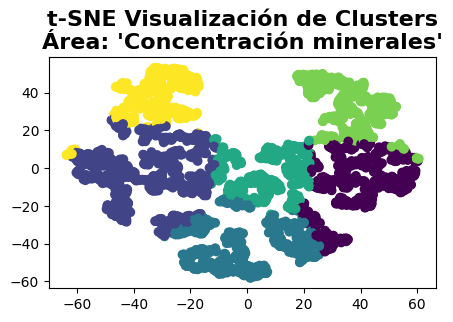

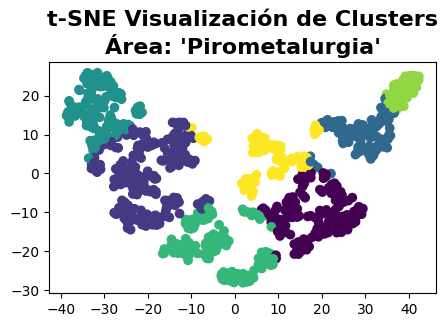

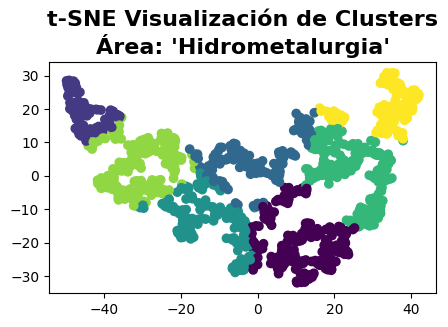

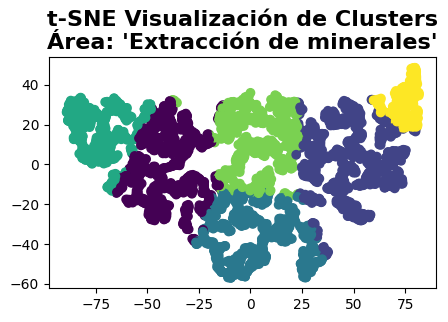

In [93]:
type_curve = "convex"
resultados_convex = proceso_completo(data, areas,
                                     ruta_carpeta_indices,
                                     target_curve = type_curve)

## Variante 2 - Uso de curva concava para calcular el valor óptimo de K

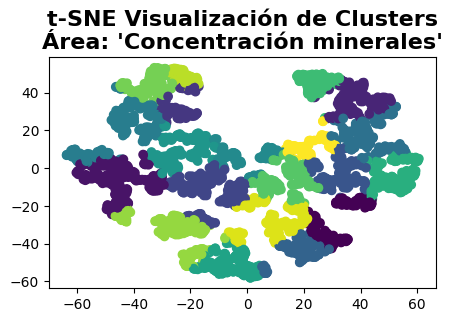

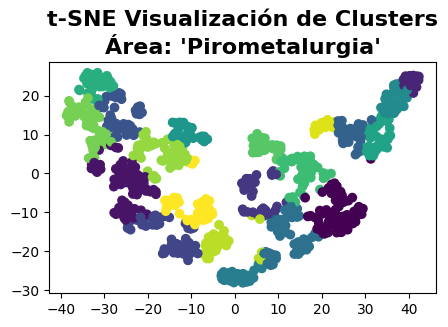

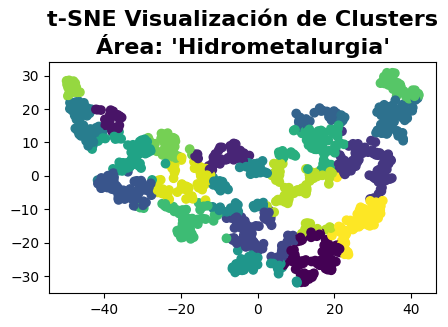

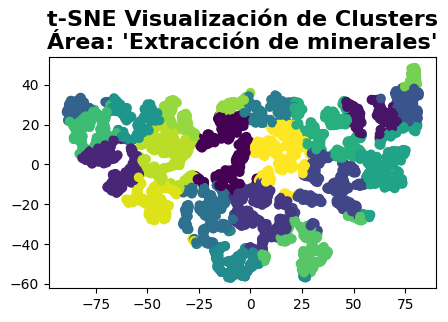

In [95]:
# Iterar por cada área usando curva 'concave' para obtener el valor óptimo de cluster
resultados_concave = proceso_completo(data, areas,
                                      ruta_carpeta_indices,
                                      target_curve= "concave")

# Análisis de los modelos de segmentación

En esta sección se cargan los modelos generados en la sección anterior y se analizan los clusters obtenidos, mostrando los términos comunes de cada grupo.

Se generan archivos .xlsx y .csv con los análisis. Los nombres de los archivos dependen de la variante que se esté revisando:


Para las frecuencias área-cluster:

+ *frecuencias_por_area_cluster_convex.xlsx*
+ *frecuencias_por_area_cluster_convex.csv*

+ *frecuencias_por_area_cluster_concave.xlsx*
+ *frecuencias_por_area_cluster_concave.csv*

Para los K términos más frecuentes:
+ *concave_frecuencias_K_terminos.xlsx*
+ *concave_frecuencias_K_terminos.csv*

+ *convex_frecuencias_K_terminos.xlsx*
+ *convex_frecuencias_K_terminos.csv*

Todos los archivos se generan en la carpeta:


```
/content/resultados
```



## Funciones útiles

In [58]:
# Crear carpeta si no existe
ruta_carpeta = "/content/resultados"
if not os.path.exists(ruta_carpeta):
    os.makedirs(ruta_carpeta)

In [29]:
def contar_terminos(texto, terminos):
  """ Función para contar términos en un texto """
  contador = Counter()
  for termino in terminos:
    ocurrencias = len(re.findall(r'\b' + re.escape(termino) + r'\b', texto.lower()))
    contador[termino] += ocurrencias
  return contador

def crear_dataframe_conteo(conteo_total):
    """ Obtener la lista de términos y sus frecuencias en un DataFrame
      Args:
        conteo_total (Counter): conntiene las frecuencias
      Returns:
        DataFrame: matriz con el conteo de los términos
    """
    # Convertir el Counter a una lista de tuplas y crear el DataFrame
    df_conteo = pd.DataFrame(conteo_total.most_common(), columns=['Término', 'Frecuencia'])
    return df_conteo

def obtener_documentos(data_by_area : pd.DataFrame, target_area : str, target_cluster : int):
  """ Obtiene los documentos de una determinada área
     Args:
        data_by_area (DataFrame): datos
        target_area (str): área que se analiza
        target_cluster (int): número de cluster que se analzia
    Returns:
        DataFrame: matriz con el conteo de los términos
  """
  # Extracción de documentos
  documentos = data_by_area[target_area].query(f"cluster == {target_cluster}")['clean_combined_text']
  df = pd.DataFrame(documentos)
  df.columns = ['documento']
  return df

def obtener_frecuencias(df : pd.DataFrame, target_area : str, target_cluster = 1, verbose = False):
  """ Obtiene la frecuencia de términos de una determinada área
   Args:
        df (DataFrame): datos
        target_area (str): área que se analiza
        target_cluster (int): número de cluster que se analiza, por defecto es 1
        verbose (bool): indicador para saber si desea imprimir resultados
    Returns:
        DataFrame: matriz con el conteo de los términos
  """
  # Contar términos en cada documento
  conteo_total = Counter()
  for documento in df['documento']:
    conteo_total += contar_terminos(documento, terminos)

  if verbose:
    print("-"*90)
    print(f"Frecuencia de términos 4.0 de cluster {target_cluster} de área '{target_area}'")
    print("-"*90)
    # Determinar el ancho máximo del término para alinear correctamente
    ancho_max_termino = max(len(termino) for termino in conteo_total)
    # Ordenar y mostrar resultados por frecuencia de mayor a menor
    for termino, frecuencia in conteo_total.most_common():
      print(f"Término 4.0: {termino:<{ancho_max_termino}}  Frecuencia: {frecuencia}")
  # Llamar a la función para obtener el DataFrame
  return crear_dataframe_conteo(conteo_total)


In [55]:
def guarda_resultados(frecuencias : pd.DataFrame,
                      ruta_carpeta : str,
                      variante : str) -> None:
  # Define las rutas de los archivos
  ruta_csv = os.path.join(ruta_carpeta, f"frecuencias_por_area_cluster_{variante}.csv")
  ruta_xlsx = os.path.join(ruta_carpeta, f"frecuencias_por_area_cluster_{variante}.xlsx")
  # Genera los archivos
  frecuencias.to_excel(ruta_xlsx, index=False)
  frecuencias.to_csv(ruta_csv, index=False)

In [49]:
def obtiene_analisis(areas, resultados_variante, verbose = False):
  lst_data_frames = []
  for area in areas:
    data_area = []
    # Obtiene frecuencias de cada cluster
    for cluster in sorted(resultados_variante[area].cluster.unique()):
      if verbose:
        print(f"Procesando cluster {cluster} de área {area}...")
      df_frecuencia = obtener_frecuencias(obtener_documentos(resultados_variante, area, cluster),
                                     area, verbose = False)
      df_frecuencia['area'] = area
      df_frecuencia['cluster'] = cluster
      lst_data_frames.append(df_frecuencia)

  # Integra todo en un solo dataframe
  return pd.concat(lst_data_frames, ignore_index = True)

In [64]:
def ver_nube_palabras(resultados : dict, selected_area :str, selected_cluster : int):
  # Obtiene los documentos del área y cluster seleccionados
  vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(1, 3))
  documentos = obtener_documentos(resultados, selected_area, selected_cluster)
  # Unir todos los documentos en una única cadena de texto
  text = ' '.join(documentos['documento'].values)

  # Crear la nube de palabras
  wordcloud = WordCloud(width=800, height=400, background_color='white',
                        collocations=False).generate(text)

  # Mostrar la nube de palabras
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f"Términos más frecuentes en el área: {selected_area} - cluster: {selected_cluster}",
          fontsize=16, fontweight="bold")
  plt.show()

In [65]:
def ver_nube_k_palabras(resultados : dict, selected_area :str, selected_cluster : int, k = 20):
  # Obtiene los documentos del área y cluster seleccionados
  vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(1, 3))
  documentos = obtener_documentos(resultados, selected_area, selected_cluster)
  # Unir todos los documentos en una única cadena de texto
  text = ' '.join(documentos['documento'].values)
  # Contar la frecuencia de cada palabra
  word_freq = Counter(text.split())
  most_common_terms = word_freq.most_common(k)
  # Crear un diccionario con los términos más comunes y sus frecuencias
  common_terms_dict = dict(most_common_terms)

  # Generar la nube de palabras con estos términos
  wordcloud = WordCloud(width=800, height=400,
                        background_color='white').generate_from_frequencies(common_terms_dict)

  # Mostrar la nube de palabras
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f"Los {k} términos más comunes en\n área: {selected_area} - cluster: {selected_cluster}",
          fontsize=16, fontweight="bold")
  plt.show()

  return pd.DataFrame(most_common_terms, columns=['término', 'frecuencia'])

In [66]:
def nube_palabras_por_area(areas, resultados):
  for area in areas:
    for cluster in sorted(resultados[area].cluster.unique()):
      ver_nube_palabras(resultados, area, cluster)

In [82]:
def obtiene_k_terminos(areas, resultados, variante : str, value_k = 10):
  lst_df_frecuencias = []
  for area in areas:
    for cluster in sorted(resultados[area].cluster.unique()):
      frecuencias = ver_nube_k_palabras(resultados, area, cluster, k=value_k)
      frecuencias['area'] = area
      frecuencias['cluster'] = cluster
      lst_df_frecuencias.append(frecuencias)
  frecuencias_k_por_area_cluster = pd.concat(lst_df_frecuencias, ignore_index = True)
  # Define las rutas de los archivos
  ruta_csv = os.path.join(ruta_carpeta, f"{variante}_frecuencias_{value_k}_terminos.csv")
  ruta_xlsx = os.path.join(ruta_carpeta, f"{variante}_frecuencias_{value_k}_terminos.xlsx")

  frecuencias_k_por_area_cluster.to_csv(ruta_csv, index = False)
  frecuencias_k_por_area_cluster.to_excel(ruta_xlsx, index = False)
  return frecuencias_k_por_area_cluster

## Clusters usando el óptimo de curva 'convex'

### Genera análisis y guarda resulatdos

In [56]:
# Genera el análisis
frecuencias_por_area_cluster = obtiene_analisis(areas, resultados_convex)

In [59]:
# Guarda resultados
guarda_resultados(frecuencias_por_area_cluster, ruta_carpeta, "convex")

In [60]:
# Listar los archivos en la carpeta
print(f"Archivos en la carpeta {ruta_carpeta}:")
for archivo in os.listdir(ruta_carpeta):
    print("\t", archivo)

Archivos en la carpeta /content/resultados:
	 frecuencias_por_area_cluster_convex.xlsx
	 frecuencias_por_area_cluster_convex.csv


### Obtiene nube de palabras para cada área-cluster

In [ ]:
# Obtiene la nube de palabras para cada área-cluster
nube_palabras_por_area(areas, resultados_convex)

### Obtiene los K términos más comunes de cada área-cluster existente

In [ ]:
frecuencias_k_terminos = obtiene_k_terminos(areas, resultados_convex, "convex")

In [75]:
# Muestra algunos registros
frecuencias_k_terminos.sample(7)

,término,frecuencia,area,cluster
172,system,318,Hidrometalurgia,4
55,according,660,Concentración minerales,5
174,mining,199,Hidrometalurgia,4
118,sensor,92,Pirometalurgia,5
181,cup,474,Hidrometalurgia,5
137,gas,133,Hidrometalurgia,0
112,power,198,Pirometalurgia,5


## Clusters usando el óptimo de curva 'concave'

### Genera análisis y guarda resultados

In [76]:
# Genera el análisis
frecuencias_por_area_cluster_concave = obtiene_analisis(areas, resultados_concave)

In [77]:
# Guarda resultados
guarda_resultados(frecuencias_por_area_cluster_concave, ruta_carpeta, "concave")

In [78]:
# Listar los archivos en la carpeta
print(f"Archivos en la carpeta {ruta_carpeta}:")
for archivo in os.listdir(ruta_carpeta):
    print("\t", archivo)

Archivos en la carpeta /content/resultados:
	 frecuencias_por_area_cluster_concave.xlsx
	 frecuencias_por_area_cluster_concave.csv
	 frecuencias_10_terminos.xlsx
	 frecuencias_por_area_cluster_convex.xlsx
	 frecuencias_10_terminos.csv
	 frecuencias_por_area_cluster_convex.csv


### Genera nube de palabras

In [ ]:
# Obtiene la nube de palabras para cada área-cluster
nube_palabras_por_area(areas, resultados_concave)

### Obtiene los K términos más comunes de cada área-cluster existente

In [ ]:
frecuencias_k_terminos_concave = obtiene_k_terminos(areas, resultados_concave, "concave")

In [86]:
frecuencias_k_terminos_concave.sample(5)

,término,frecuencia,area,cluster
82,mining,462,Concentración minerales,8
773,mine,418,Extracción de minerales,17
541,method,162,Hidrometalurgia,14
791,data,662,Extracción de minerales,19
205,cup,116,Pirometalurgia,0
